In [1]:
from torchvision.datasets.utils import download_url

In [2]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

In [3]:
import tarfile

In [4]:
with tarfile.open('./oxford-iiit-pet.tgz','r:gz') as tar:
    tar.extractall(path='./data')

In [5]:
from torch.utils.data import Dataset

In [6]:
import os
DATA_DIR = './data/oxford-iiit-pet/images'
files = os.listdir(DATA_DIR)
files[:5]

['scottish_terrier_38.jpg',
 'British_Shorthair_165.jpg',
 'american_pit_bull_terrier_200.jpg',
 'chihuahua_21.jpg',
 'Maine_Coon_56.jpg']

In [7]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

In [8]:
from PIL import Image


In [9]:
def open_image(path):
    with open(path,'rb') as f:
        img=Image.open(f)
        return img.convert('RGB')

In [10]:
#Custom Pytorch Dataset
class PetsDataset(Dataset): #dataset class from torch.utils.data
    def __init__(self,root,transform):
        super().__init__()
        self.root = root
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes = list(set(parse_breed(fname) for fname in files))
        self.transform = transform
  
    def __len__(self):
        return len(self.files)

    def __getitem__(self,i):
        fname = self.files[i]
        fpath = os.path.join(self.root,fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(parse_breed(fname))
        return img,class_idx

In [11]:
import torchvision.transforms as T

img_size=224
imagenet_stats=([0.485,0.456,0.406],[0.229,0.224,0.225])
dataset = PetsDataset(DATA_DIR,T.Compose([T.Resize(img_size),
                                          T.Pad(8,padding_mode='reflect'),
                                          T.RandomCrop(img_size),
                                          T.ToTensor(),
                                          T.Normalize(*imagenet_stats)]))

In [12]:
len(dataset)

7390

In [13]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def denormalize(images,means,stds):
    if len(images.shape) == 3:
        images =  images.unsqueeze(0)
    means = torch.tensor(means).reshape(1,3,1,1)
    stds  = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds + means

def show_image(img_tensor,label):
    print('Label:', dataset.classes[label], '('+str(label)+')')
    img_tensor =  denormalize(img_tensor, *imagenet_stats)[0].permute((1,2,0))
    plt.imshow(img_tensor)

Label: beagle (34)


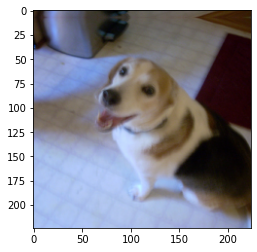

In [15]:
show_image(*dataset[5])

In [16]:
from torch.utils.data import random_split

In [17]:
val_pct = 0.1
val_size= int(val_pct * len(dataset))

In [18]:
train_ds, valid_ds = random_split(dataset,[len(dataset)-val_size, val_size])

In [19]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
valid_dl = DataLoader(valid_ds,batch_size*2,num_workers=4,pin_memory=True)

In [20]:
from torchvision.utils import make_grid

In [21]:
def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([])
        ax.set_yticks([])
        images = denormalize(images[:64],*imagenet_stats)
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break

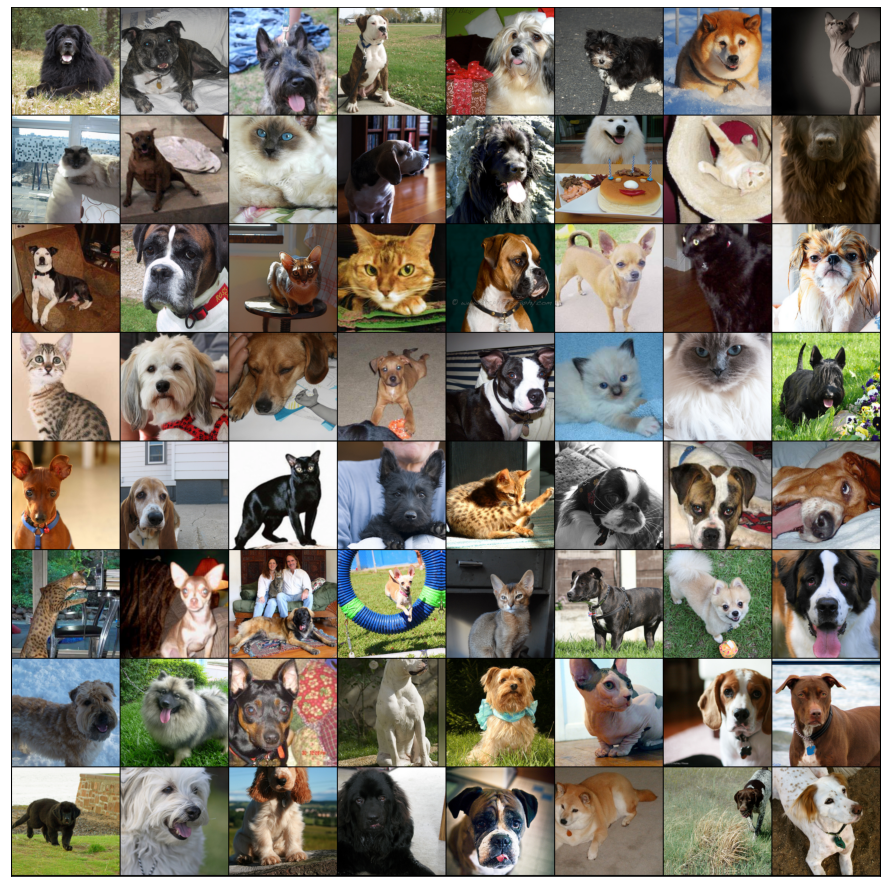

In [22]:
show_batch(train_dl)

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader(): #wrapper over DataLoader class, to push it to device and create __iter__ class for taking full advantage of GPU
    def __init__(self,data_loader,device):
        self.data_loader = data_loader
        self.device = device
    
    def __iter__(self): #this class makes the magic of GPU happen
        for batch in self.data_loader:
            yield(to_device(batch,self.device))
    
    def __len__(self):
        return len(self.data_loader)

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
class ImageBase(nn.Module):
    def train_step(self,X_batch):
        images,labels = X_batch
        out = self.forward(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def valid_step(self,X_batch):
        images,labels = X_batch
        out = self.forward(images)
        loss = F.cross_entropy(out,labels)
        _,preds = torch.max(out,dim=1)
        acc = torch.tensor(torch.sum(preds==labels).item()/len(preds))
        return {'loss':loss,'acc':acc}

In [27]:
from torchvision import models

In [28]:
class PetsModel(ImageBase):
    def __init__(self,num_classes,pretrained=True):
        super().__init__()
        self.network = models.resnet34(pretrained=pretrained)
        self.network.fc = nn.Linear(self.network.fc.in_features,num_classes)

    def forward(self,xb):
        return self.network(xb)

In [29]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model,loader):
    model.eval()
    out = [model.valid_step(batch) for batch in loader]
    batch_loss = [x['loss'] for x in out]
    batch_acc  = [x['acc'] for x in out]
    epoch_loss = torch.stack(batch_loss).mean()
    epoch_acc  = torch.stack(batch_acc).mean()
    print(f"loss is {epoch_loss} and acc is {epoch_acc}")

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,valid_loader,weight_decay=0,grad_clip=None,optim_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    optimizer = optim_func(model.parameters(),max_lr,weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader):
            loss = model.train_step(batch)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
        evaluate(model,valid_loader)

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [31]:
model = PetsModel(len(dataset.classes))
to_device(model,device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


PetsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [32]:
evaluate(model,valid_dl)

loss is 3.8356008529663086 and acc is 0.01955275982618332


In [35]:
epochs=6
max_lr = 0.01
grad_clip=0.1
weight_decay = 1e-4
optim_func = torch.optim.Adam

In [36]:
fit_one_cycle(epochs,max_lr,model,train_dl,valid_dl,weight_decay,grad_clip,optim_func)


loss is 325.26361083984375 and acc is 0.02859134040772915



loss is 3.0522494316101074 and acc is 0.19116532802581787



loss is 2.0929512977600098 and acc is 0.4170309007167816



loss is 1.1835567951202393 and acc is 0.6340644359588623



loss is 0.7146958112716675 and acc is 0.7590084671974182



loss is 0.6616355180740356 and acc is 0.8024977445602417


In [37]:
model_from_scratch = PetsModel(len(dataset.classes),pretrained=False)
to_device(model_from_scratch,device)

PetsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [38]:
evaluate(model_from_scratch,valid_dl)

loss is 34.00249481201172 and acc is 0.02102835848927498


In [39]:
fit_one_cycle(epochs,max_lr,model_from_scratch,train_dl,valid_dl,weight_decay,grad_clip,optim_func)


loss is 190.3902130126953 and acc is 0.02175540290772915



loss is 3.8049778938293457 and acc is 0.06817439198493958



loss is 3.501420497894287 and acc is 0.11976872384548187



loss is 3.2311601638793945 and acc is 0.10607533901929855



loss is 2.8501436710357666 and acc is 0.19895632565021515



loss is 2.6652674674987793 and acc is 0.2549344301223755
